In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define paths to dataset directories
train_dir = r"C:\Users\HP\Desktop\pest demo\training"
val_dir = r"C:\Users\HP\Desktop\pest demo\validation"
test_dir =r"C:\Users\HP\Desktop\pest demo\testing"

In [3]:
# Define image dimensions
image_size = (224, 224)
num_classes = 13  # Number of categories including "Healthy"

In [4]:
# Define batch size
batch_size = 32

In [5]:
# Create data generators for training, validation, and test sets
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Disable shuffling for the test set to evaluate predictions properly
)


Found 7206 images belonging to 13 classes.
Found 701 images belonging to 13 classes.
Found 1733 images belonging to 13 classes.


In [6]:
# Load pre-trained GoogLeNet model (InceptionV3) without top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

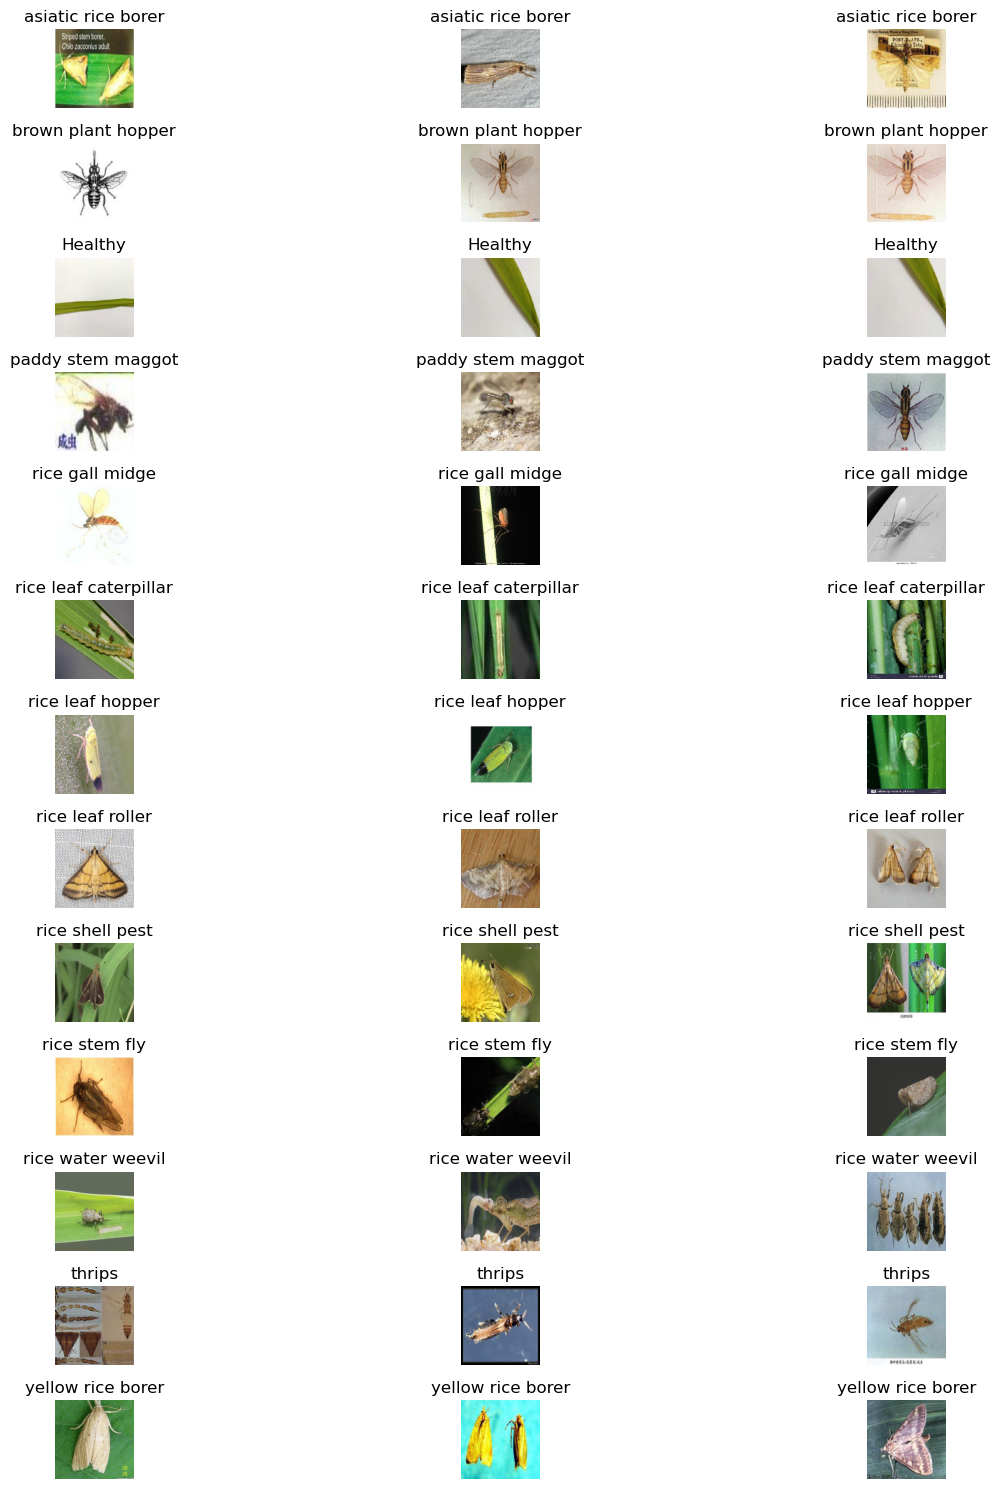

In [7]:


# Function to visualize images from each class in the dataset directory
def visualize_images(dataset_dir, num_images_per_class=3):
    class_names = os.listdir(dataset_dir)
    num_classes = len(class_names)

    # Create a grid of subplots
    fig, axes = plt.subplots(num_classes, num_images_per_class, figsize=(15, 15))

    # Loop through each class
    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(dataset_dir, class_name)
        image_files = os.listdir(class_dir)[:num_images_per_class]

        # Load and display images from the current class
        for j, image_file in enumerate(image_files):
            image_path = os.path.join(class_dir, image_file)
            img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
            axes[i, j].imshow(img)
            axes[i, j].set_title(class_name)
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
dataset_dir = r"C:\Users\HP\Desktop\pest demo\training"
visualize_images(dataset_dir)


In [8]:
# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False


In [9]:
# Add custom classification layers on top of the pre-trained model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [10]:
print("--------------------------------------\n")
model.summary()
print("--------------------------------------\n")

--------------------------------------



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ ?                      │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

--------------------------------------



In [11]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
print("--------------------------------------\n")
print("Training Started.\n")

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

print("Training Finished.\n")
print("--------------------------------------\n")

--------------------------------------

Training Started.

Epoch 1/10


c:\Users\HP\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 87/225 ━━━━━━━━━━━━━━━━━━━━ 2:58 1s/step - accuracy: 0.5179 - loss: 1.6808

In [ ]:
# Print training accuracy
print("Training Accuracy:", history.history['accuracy'])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

Training Accuracy: [0.7291608452796936, 0.78125, 0.8442988395690918, 0.875, 0.885280191898346, 0.875, 0.9049344658851624, 0.75, 0.9151101112365723, 0.875]
55/55 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.8941 - loss: 0.7901
Test loss: 0.945289671421051
Test accuracy: 0.8678591847419739


In [ ]:
# Make predictions on new images
def predict_pest(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    img_array /= 255.0  # Normalize pixel values

    prediction = model.predict(img_array)
    predicted_class_index = tf.argmax(prediction, axis=1)[0]

    pests = ['Healthy', 'Asiatic rice borer', 'Brown plant hopper', 'Paddy stem maggot', 'Rice gall midge', 'Rice leaf caterpillar', 'Rice leaf hopper','rice stem fly','rice water weevil','rice shell pest','yellow rice borer','thrips','rice leaf roller']

    if predicted_class_index == 0:
        return "No pest found: Healthy"
    else:
        return f"Pest found, Type: {pests[predicted_class_index]}"



In [ ]:
# Example usage:
image_path = r"C:\Users\HP\Desktop\combined datsets\Training\Pest Infestation\rice leaf caterpillar\1 (85).jpg"
predicted_pest = predict_pest(image_path)
print(f"Pest Prediction: {predicted_pest}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Pest Prediction: Pest found, Type: Rice leaf caterpillar


In [ ]:
# Example usage:
image_path = r"C:\Users\HP\Desktop\combined datsets\Training\Pest Infestation\rice leaf caterpillar\1 (81).jpg"
predicted_pest = predict_pest(image_path)
print(f"Pest Prediction: {predicted_pest}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Pest Prediction: Pest found, Type: Rice leaf caterpillar


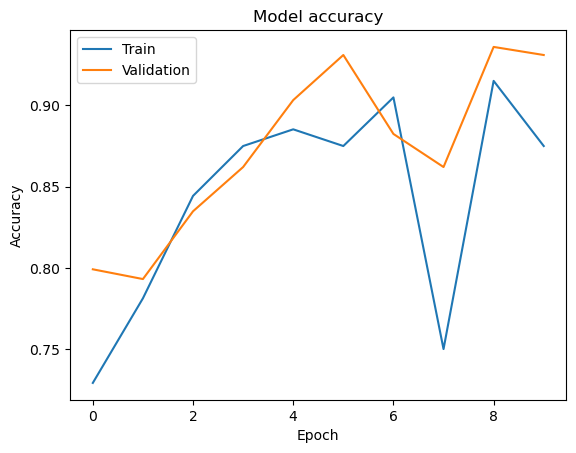

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy_plot.png')
plt.show()

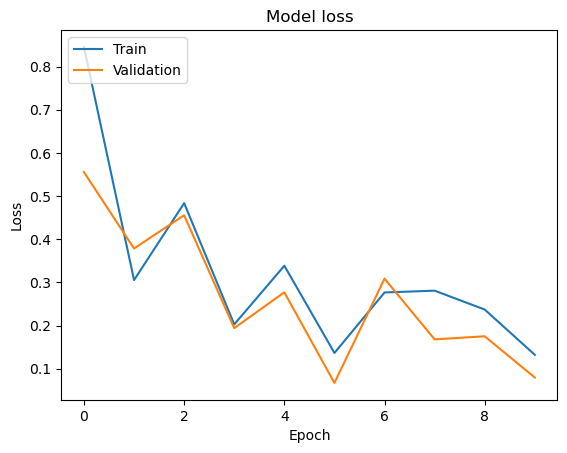

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss_plot.png')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Make predictions on the test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
true_classes = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(true_classes, y_pred_classes, target_names=class_labels))


55/55 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step
                       precision    recall  f1-score   support

              Healthy       0.99      1.00      1.00       234
   asiatic rice borer       0.84      0.96      0.90       100
   brown plant hopper       0.97      0.64      0.77        58
    paddy stem maggot       0.78      0.94      0.85        65
      rice gall midge       0.99      0.97      0.98       158
rice leaf caterpillar       0.99      0.93      0.96        75
     rice leaf hopper       0.00      0.00      0.00       121
     rice leaf roller       0.42      0.99      0.59       101
      rice shell pest       1.00      0.89      0.94       265
        rice stem fly       0.77      0.99      0.87       110
    rice water weevil       0.99      0.90      0.94       250
               thrips       0.94      1.00      0.97       100
    yellow rice borer       0.99      0.88      0.93        96

             accuracy                           0.87      1733
            ma